In [6]:
import datalabframework
from pyspark.sql.functions import col
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.sql import Window
from datalabframework.spark.utils import unidecode
import pandas as pd
import os
from datalabframework.spark import dataframe
import numpy as np
os.environ['PYSPARK_PYTHON'] = '/opt/conda/bin/python'
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from models import *
import seaborn as sns
import pickle
from elastictools.doctools import DocTools
import json

In [2]:
a = {'x': 3, 'y' : None}
a.update({'y': 5})
a

{'x': 3, 'y': 5}

In [3]:
[None] * 3

[None, None, None]

In [7]:
#load fact
datalabframework.project.load()

Py4JJavaError: An error occurred while calling None.org.apache.spark.sql.SparkSession.
: java.lang.IllegalStateException: Cannot call methods on a stopped SparkContext.
This stopped SparkContext was created at:

org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
sun.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
sun.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
sun.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
java.lang.reflect.Constructor.newInstance(Constructor.java:423)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
py4j.GatewayConnection.run(GatewayConnection.java:238)
java.lang.Thread.run(Thread.java:748)

The currently active SparkContext was created at:

org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
sun.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
sun.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
sun.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
java.lang.reflect.Constructor.newInstance(Constructor.java:423)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
py4j.GatewayConnection.run(GatewayConnection.java:238)
java.lang.Thread.run(Thread.java:748)
         
	at org.apache.spark.SparkContext.assertNotStopped(SparkContext.scala:100)
	at org.apache.spark.sql.SparkSession.<init>(SparkSession.scala:91)
	at org.apache.spark.sql.SparkSession.<init>(SparkSession.scala:88)
	at sun.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
	at sun.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
	at sun.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
	at java.lang.reflect.Constructor.newInstance(Constructor.java:423)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:238)
	at py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
	at py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)


In [ ]:
engine = datalabframework.project.engine()
spark = engine.context()
fact_transaction = engine.load('fact_table').select('sku_id', 'sku_name', 'transaction_date', 'quantity', \
                                                    'doc_type', 'unit_price', 'cat_id', 'cat_group_id', \
                                                    'cat_root_id', 'cat_name', 'cat_group_name', 'cat_root_name', \
                                                    'brand_name', 'brand_id', 'product_state_id')

In [ ]:
#extract quantity 
product_quantity_date = fact_transaction.where(F.expr('doc_type == "PTX"') | F.expr('doc_type == "HDF"'))\
                .where(F.expr('unit_price != 0'))\
                .groupby('sku_id', 'sku_name', 'transaction_date', 'cat_id', 'cat_group_id', 'cat_root_id', 'cat_name',\
                         'cat_group_name', 'cat_root_name', 'brand_name', 'brand_id')\
                .agg(F.sum('quantity').alias('daily_quantity'), F.avg('unit_price').alias('daily_price'))\
                .orderBy('transaction_date')

In [4]:
product_list = fact_transaction.where(F.col('product_state_id') == 1).select('sku_id', 'sku_name', 'quantity', 'unit_price')\
                .withColumn('revenue', F.col('quantity') * F.col('unit_price'))\
                .groupby('sku_id', 'sku_name').agg(F.sum('revenue').alias('total_revenue'))\
                .sort(F.desc('total_revenue')).toPandas()[['sku_id', 'sku_name']].values

In [5]:
product_quantity_date = product_quantity_date.toPandas()
product_quantity_date['daily_quantity'] = product_quantity_date['daily_quantity'].astype(np.int64)

In [6]:
def select_product(product_quantity_date, sku_id):
    total_by_date = product_quantity_date[product_quantity_date['sku_id'] == sku_id]
    return total_by_date

In [7]:
def clean_data(total_by_date):
    """
    Convert data from spark to pandas, clean data, create dummy variables of 
    day of week, month of year, day of month.
    
    Parameters
    ----------
    total_by_date: Spark.DataFrame
        Total sales of a category by date
    
    Returns
    -------
    Pandas.DataFrame
        Total sales of a category by date with clean the outliers and dummy variables
    """
    start_date = total_by_date['transaction_date'].min()
    end_date = total_by_date['transaction_date'].max()
    total_by_date = total_by_date.set_index('transaction_date')
    full_date = pd.DataFrame({'date_ts':pd.date_range(start_date, end_date)}).set_index('date_ts')
    full_quantity_total_product = total_by_date.join(full_date, how = 'right').fillna(0)
    full_quantity_total_product['week'] = full_quantity_total_product.index.to_series().dt.week
    full_quantity_total_product['year'] = full_quantity_total_product.index.to_series().dt.year
    full_quantity_total_product['month'] = full_quantity_total_product.index.to_series().dt.month
    full_quantity_total_product['dow'] = full_quantity_total_product.index.to_series().dt.dayofweek
    full_quantity_total_product['dom'] = full_quantity_total_product.index.to_series().dt.day
    full_quantity_total_product.index.freq = 'D'
    agg_week= full_quantity_total_product.groupby('dow').agg({'daily_quantity': 'mean'})
    agg_week.columns = ['agg_total_week']
    full_quantity_total_product_dummies = pd.get_dummies(full_quantity_total_product, prefix = ['dow', 'moy', 'dom'],\
                                                         columns = ['dow', 'month', 'dom'], drop_first = True)
    
    return full_quantity_total_product_dummies

In [8]:
def forecast_process(data_series, predictor_cols, target_col, model_class, length_test, n_cv = 30):
    """
    All prorecess for validate a model with a series
    
    Parameters
    ----------
    data_series: Pandas.Series
        A given time series
    predictor_cols: array-like
        Column names of predictors
    target_col: string
        Column name of response column
    model_class: TimeseriesForecastingModel
        Class name of selected model
    n_test: int
        Number selected period at the end of series for test part
    n_cv: int
        Number folds for prediction
        
    Returns
    -------
    Axes: 
        Visualization for train, test, validation
    Tuple:
        Model of forecasting
    Pandas.Series:
        Error between prediction and actual value on test
    Pandas.DataFrame:
        Information of errors in cross validation
    Dict:
        Total error of cross validation
    """
    selected_cols = list(set(predictor_cols).union(set(target_col)))
    model = model_class(data_series, predictor_cols, target_col)
    model.fit()
    list_cv_preds, cv_error, cv_total_error = model.cross_validation(n_cv, length_test)
    return cv_error, cv_total_error

In [25]:
def all_process_on_timeseries(full_quantity_total_product, models, length_test = 30, n_cv = 30):
    all_model = models
    using_predictor_col = [SeasonalNaiveModel, UpgradeSeasonModel, SarimaxModel]
#     print(full_quantity_total_product)
    train_series = full_quantity_total_product.iloc[:-length_test]
    test_series = full_quantity_total_product.iloc[-length_test:]
    best_model = None
    best_mean_error = math.inf
    for model_class in all_model:
        predictor_cols = []
        if (model_class in using_predictor_col):
            predictor_cols = [f'dow_{i}' for i in range(1, 7)] + [f'moy_{i}' for i in range(2, 13)]\
                            + [f'dom_{i}' for i in range(1, 32)]
            predictor_cols = list(set(predictor_cols).intersection(set(train_series.columns)))
        try:
            cv_error, cv_total_error = forecast_process(train_series, predictor_cols, ['daily_quantity'], model_class, length_test, n_cv)
            if (cv_total_error['MAPE'] < best_mean_error):
                best_mean_error = cv_total_error['MAPE']
                best_model = model_class
        except:
            continue
    if (best_model in using_predictor_col):
        predictor_cols = [f'dow_{i}' for i in range(1, 7)] + [f'moy_{i}' for i in range(2, 13)]\
                            + [f'dom_{i}' for i in range(1, 32)]
        predictor_cols = list(set(predictor_cols).intersection(set(full_quantity_total_product.columns)))
    if not best_model:
        return None, None, None, None, None, None
    model = best_model(train_series, predictor_cols, ['daily_quantity'])
    model.fit()
    preds = model.forecast(test_series.index[0], test_series.index[-1])
    preds = preds.round()
    test_error, test_total_error = model.measure_error(test_series, preds)
    naive_model = NaiveModel(train_series, [], ['daily_quantity'])
    naive_model.fit()
    preds_naive = naive_model.forecast(test_series.index[0], test_series.index[-1])
    preds_naive = preds_naive.round()
    naive_error, naive_total_error = naive_model.measure_error(test_series, preds_naive)
    wape = test_total_error['MAPE']/naive_total_error['MAPE']
    mean_test = test_series['daily_quantity'].mean()
    mean_preds = preds.mean()
    return model.getLabel(), test_total_error['MAPE'], test_total_error['MAD'], wape, mean_test, mean_preds

In [26]:
def perform_cv_process(product_id, product_name, full_quantity_total_product, models, n_test = 5, length_test = 30, n_cv = 30):
    loc = full_quantity_total_product.shape[0]
    is_valid = 0
    best_models = []
    flat_result = []
    attr_names = ['product_id', 'product_name', 'start_date', 'end_date', 'best_model', 'MAPE', 'MAD', 'wape', 'mean_test', 'mean_preds']
    for i in range(n_test):
        train_series = full_quantity_total_product.iloc[:loc]
        result = [product_id, product_name, full_quantity_total_product.index[loc - length_test], full_quantity_total_product.index[loc - 1]]
        result.extend(all_process_on_timeseries(train_series, models, length_test, n_cv))
        if result[3]:
            is_valid += 1 
            flat_result.append(dict(zip(attr_names, result)))
        loc = loc - length_test
    if not is_valid:
        return None
    return flat_result

In [27]:
flat_result_all_productt = []
all_model = {'Average': AverageModel, 'Naive': NaiveModel, 'Drift': DriftModel, 'SeasonalNaive':SeasonalNaiveModel, \
                 'UpgradeSeason':UpgradeSeasonModel, 'StandardArima': StandardArimaModel, 'SES':SimpleExpSmothingModel, \
                 'Holt': HoltModel, 'HoltWinter': HoltWinterModel, 'DecomposeArima': DecomposeArimaModel}
using_predictor_col = [SeasonalNaiveModel, UpgradeSeasonModel, SarimaxModel]
selected_models_cat = {}
n = 1
for product in product_list[:1]:
    df = select_product(product_quantity_date, product[0])
    df['transaction_date'] = pd.to_datetime(df['transaction_date'])
    df_clean = clean_data(df)
    df_clean = df_clean['daily_quantity'].reset_index()
    df_group = df_clean.groupby(pd.Grouper(key ='date_ts', freq = 'M'))['daily_quantity'].sum()
    df_group = df_group[0:-1]
    df_group = pd.DataFrame(df_group)
    df_group['moy'] = df_group.index.to_series().dt.month
    df_group = pd.get_dummies(df_group, prefix = ['moy'], columns = ['moy'], drop_first = True)
    all_model = [AverageModel, NaiveModel, DriftModel, SeasonalNaiveModel, UpgradeSeasonModel, StandardArimaModel,\
                  SimpleExpSmothingModel, HoltModel, HoltWinterModel, DecomposeArimaModel]
    flat_result = perform_cv_process(product[0], product[1], df_group, all_model, 5, 1, 25)
    if flat_result:
        flat_result_all_cat.extend(flat_result)
        json.dump(flat_result_all_cat,open('product_month_series_prediction_multiple_test_set.json', 'w', encoding = 'utf8'))

/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/conda/lib/python3.6/site-packages/s

NameError: name 'flat_result_all_cat' is not defined

In [46]:
product_quantity_date.groupby(['sku_id', 'sku_name']).agg({'daily_quantity': 'count'})\
                     .sort_values('daily_quantity', ascending = False).head(20)

,,daily_quantity
sku_id,sku_name,
1301656,xử lý phần mềm,823
1203141,phần mềm kaspersky internet security 1 máy tính,823
1201762,ổ cứng hdd wd blue 1tb sata3 7200rpm (wd10ezex),823
1201758,"ổ cứng hdd wd elements portable 1tb 2.5"" 3.0 (wdbuzg0010bbk-wesn)",823
1202982,bàn phím+chuột máy tính logitech mk120,823
1201747,"ổ cứng hdd pc seagate barracuda 1tb 3.5"" sata (st1000dm010)",823
1202903,bàn phím dell kb216-black,823
1207888,túi đệm 15'',823
1203139,phần mềm kaspersky antivirus 1 máy tính,823


In [34]:
product_quantity_date[product_quantity_date['cat_root_name'] == 'laptop'].groupby(['sku_id', 'sku_name']).agg({'daily_quantity':'count'})\
                     .sort_values('daily_quantity', ascending = False).head(20)

,,daily_quantity
sku_id,sku_name,
1701509,máy tính xách tay/ laptop dell vostro 3468 (f3468-70090698) (đen),371
1603607,máy tính xách tay/ laptop dell vostro 3468 (f3468-70088614) (đen),364
1603431,máy tính xách tay/ laptop dell vostro 3568-v3568b (đen),352
1701256,máy tính xách tay/ laptop acer e5-475-31kc (nx.gcusv.001) (xám),349
1603447,máy tính xách tay/ laptop dell vostro 3568-xf6c61 (đen),339
1703469,máy tính xách tay/ laptop dell inspiron 15 5570-m5i5238w (bạc),323
1700953,máy tính xách tay/ laptop dell vostro 3568-v3568a (đen),321
1701547,máy tính xách tay/ laptop dell inspiron 14 3467-c4i51107 (đen),313
1603884,máy tính xách tay/ laptop dell inspiron 14 3467-m20nr2 (đen),307


In [47]:
df = select_product(product_quantity_date, '1201758')
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
df_clean = clean_data(df)
df_clean = df_clean['daily_quantity'].reset_index()
df_group = df_clean.groupby(pd.Grouper(key ='date_ts', freq = 'M'))['daily_quantity'].sum()
df_group = df_group[0:-1]
df_group = pd.DataFrame(df_group)
df_group['moy'] = df_group.index.to_series().dt.month
df_group = pd.get_dummies(df_group, prefix = ['moy'], columns = ['moy'], drop_first = True)

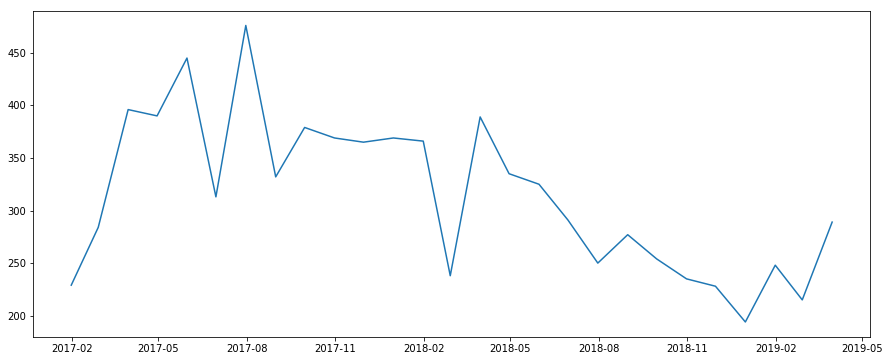

In [48]:
plt.figure(figsize = (15, 6))
plt.plot(df_group['daily_quantity'])

In [44]:
start_date = end_date = pd.to_datetime('2019-03-31') 
pd.date_range(start_date, end_date, freq = 'M')

DatetimeIndex(['2019-03-31'], dtype='datetime64[ns]', freq='M')

In [49]:
all_model = [AverageModel, NaiveModel, DriftModel, SeasonalNaiveModel, UpgradeSeasonModel, StandardArimaModel,\
              SimpleExpSmothingModel, HoltModel, HoltWinterModel, DecomposeArimaModel]
flat_result = perform_cv_process('gg', 'gg', df_group, all_model, 5, 1, 20)

/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/conda/lib/python3.6/site-packages/s

In [41]:
pd.DataFrame(flat_result)

,MAD,MAPE,best_model,end_date,mean_preds,mean_test,product_id,product_name,start_date,wape
0,15.0,3.750000,SeasonalNaive,2018-09-30,19.0,4.0,gg,gg,2018-09-30,5.000000
1,17.0,2.428571,SeasonalNaive,2018-08-31,24.0,7.0,gg,gg,2018-08-31,2.125000
2,53.0,3.533333,UpgradeSeason,2018-07-31,68.0,15.0,gg,gg,2018-07-31,1.394737
3,32.0,0.603774,UpgradeSeason,2018-06-30,85.0,53.0,gg,gg,2018-06-30,3.555556
4,59.0,1.340909,SeasonalNaive,2018-05-31,103.0,44.0,gg,gg,2018-05-31,1.638889


In [18]:
x_ = pd.DataFrame()

In [20]:
x_['index'] = np.arange(23, 23 + 5)

In [21]:
x_

,index
0,23
1,24
2,25
3,26
4,27


In [ ]:
flat_result

In [91]:
agg_wape

0.2728092755179182

In [92]:
all_results

[models.HoltWinterModel,
 models.SeasonalNaiveModel,
 models.HoltWinterModel,
 models.SeasonalNaiveModel,
 models.SeasonalNaiveModel]

In [93]:
tmp

[0.09281779182392914,
 0.08151809415294094,
 0.09322125022952558,
 0.07387535427744413,
 0.07641165327390215]

In [4]:
def init():
    #load fact
    dlf = datalabframework.project.load()
    engine = dlf.engine()
    spark = engine.context()
    fact_transaction = engine.load('fact_table').select('sku_id', 'sku_name', 'transaction_date', 'quantity', \
                                                        'doc_type', 'unit_price', 'cat_id', 'cat_group_id', \
                                                        'cat_root_id', 'cat_name', 'cat_group_name', 'cat_root_name')
    product_quantity_date = fact_transaction.where(F.expr('doc_type == "PTX"') | F.expr('doc_type == "HDF"'))\
                .where(F.expr('unit_price != 0'))\
                .groupby('sku_id', 'sku_name', 'transaction_date', 'cat_id', 'cat_group_id', 'cat_root_id', 'cat_name', 'cat_group_name', 'cat_root_name')\
                .agg(F.sum('quantity').alias('daily_quantity'), F.avg('unit_price').alias('daily_price'))\
                .orderBy('transaction_date')
    all_cat_name = product_quantity_date.select('cat_name', 'cat_id').distinct().toPandas()[['cat_name', 'cat_id']].values
    all_cat_root_name = product_quantity_date.select('cat_root_name', 'cat_root_id').distinct().toPandas()[['cat_root_name', 'cat_root_id']].values
    all_cat = []
    for cat_name in all_cat_name:
        all_cat.append((tuple(cat_name), (cat_name[0], None)))
    for cat_root_name in all_cat_root_name:
        all_cat.append((tuple(cat_root_name), (None, cat_root_name[0])))
    all_cat.append((tuple(['total', '000000']), (None, None)))
    product_quantity_date = product_quantity_date.toPandas()
    product_quantity_date['daily_quantity'] = product_quantity_date['daily_quantity'].astype(np.int64)
    return product_quantity_date, all_cat

In [17]:
d = {}

In [19]:
for t in all_cat:
    d[t[0]] = t[1]

In [15]:
all_cat[0][0][0]

'switch tplink'

In [12]:
dict(all_cat[1])

{'router wifi toto link': None}

In [26]:
def select_category(product_quantity_date, cat_name = None, cat_root_name = None):
    """
    Select all transactions of a category (or all products) and caculate total sale of this category by date.
    
    Parameters
    ----------
    product_quantity_date: Spark.DataFrame
        Arregation quantity dataframe of all sku and transaction date
    cat_name: string
        Name of selected category
    
    Returns
    -------
    Spark.DataFrame
        Total sales of a category by date
    """
    if cat_name:
        cat_trans = product_quantity_date[product_quantity_date['cat_name'] == cat_name]
    elif cat_root_name:
        cat_trans = product_quantity_date[product_quantity_date['cat_root_name'] == cat_root_name]
    else:
        cat_trans = product_quantity_date[product_quantity_date['sku_id']!= "1206838"]\
                                         [product_quantity_date['sku_id']!= "1207652"]
    total_by_date = cat_trans.groupby('transaction_date').agg({'daily_quantity':'sum'}).reset_index()
    return total_by_date

In [27]:
product_quantity_date, all_cat = init()

In [5]:
cat_revenue = []
for cat in all_cat:
    cat_name, cat_root_name = cat[1]
    if cat_name:
        cat_trans = product_quantity_date[product_quantity_date['cat_name'] == cat_name]
    elif cat_root_name:
        cat_trans = product_quantity_date[product_quantity_date['cat_root_name'] == cat_root_name]
    else:
        cat_trans = product_quantity_date[product_quantity_date['sku_id']!= "1206838"]\
                                             [product_quantity_date['sku_id']!= "1207652"]
    cat_trans['revenue'] = cat_trans['daily_quantity']  * cat_trans['daily_price']
    total_revenue = cat_trans['revenue'].sum()
    cat_revenue.append([cat, total_revenue])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


In [6]:
sort_cat_revenue = sorted(cat_revenue, key = lambda x:x[1], reverse  = True)

In [28]:
def fix_outliers(row, agg_week, not_outlier_range):
    if ((row['daily_quantity'] < not_outlier_range[0]) | (row['daily_quantity'] > not_outlier_range[1])):
        return agg_week.loc[row.loc['dow']].values[0]
    return row['daily_quantity']

In [29]:
def fix_value_tet_holiday(row, agg_week):
    if row['daily_quantity'] == 0:
        return agg_week.loc[row.loc['dow']].values[0]
    return row['daily_quantity']

In [30]:
def remove_outliers(full_quantity_total_product_dummies, agg_week):
    values = full_quantity_total_product_dummies['daily_quantity'].values
    q25 = np.quantile(values, 0.25)
    q75 = np.quantile(values, 0.75)
    IQR = q75 - q25
    min_value_outlier = q25 - 1.5 * IQR
    max_value_outlier = q75 + 1.5 * IQR
    full_quantity_total_product_dummies['daily_quantity'] = full_quantity_total_product_dummies\
                                        .apply(fix_outliers, args = (agg_week, (min_value_outlier, max_value_outlier)), axis = 1)
    return full_quantity_total_product_dummies

In [77]:
def clean_data(total_by_date, end_date):
    """
    Convert data from spark to pandas, clean data, create dummy variables of 
    day of week, month of year, day of month.
    
    Parameters
    ----------
    total_by_date: Spark.DataFrame
        Total sales of a category by date
    
    Returns
    -------
    Pandas.DataFrame
        Total sales of a category by date with clean the outliers and dummy variables
    """
    start_date = total_by_date['transaction_date'].min()
    end_date = end_date
    total_by_date = total_by_date.set_index('transaction_date')
    full_date = pd.DataFrame({'date_ts':pd.date_range(start_date, end_date)}).set_index('date_ts')
    full_quantity_total_product = total_by_date.join(full_date, how = 'right').fillna(0)
    full_quantity_total_product['week'] = full_quantity_total_product.index.to_series().dt.week
    full_quantity_total_product['year'] = full_quantity_total_product.index.to_series().dt.year
    full_quantity_total_product['month'] = full_quantity_total_product.index.to_series().dt.month
    full_quantity_total_product['dow'] = full_quantity_total_product.index.to_series().dt.dayofweek
    full_quantity_total_product['dom'] = full_quantity_total_product.index.to_series().dt.day
    full_quantity_total_product.index.freq = 'D'
    agg_week= full_quantity_total_product.groupby('dow').agg({'daily_quantity': 'mean'})
    agg_week.columns = ['agg_total_week']
    full_quantity_total_product['daily_quantity'] = full_quantity_total_product\
                                                        .apply(fix_value_tet_holiday, args = (agg_week,), axis = 1)
    full_quantity_total_product_dummies = pd.get_dummies(full_quantity_total_product, prefix = ['dow', 'moy', 'dom'],\
                                                         columns = ['dow', 'month', 'dom'], drop_first = True)
    
    return full_quantity_total_product_dummies

In [32]:
def add_holiday(full_quantity_total_product, file_name):
    holiday_info = pd.read_csv(file_name)
    holiday_info.columns = ['date', 'special_day_code', 'special_day_name']
    holiday_info = holiday_info.set_index('date')
    full_quantity_total_product = full_quantity_total_product.join(holiday_info)
    full_quantity_total_product_dummies = pd.get_dummies(full_quantity_total_product, prefix = 'holiday', \
                                                         columns = ['special_day_code'], drop_first = True)
    return full_quantity_total_product_dummies

In [12]:
def forecast_process(data_series, predictor_cols, target_col, model_class):
    """
    All prorecess for validate a model with a series
    
    Parameters
    ----------
    data_series: Pandas.Series
        A given time series
    predictor_cols: array-like
        Column names of predictors
    target_col: string
        Column name of response column
    model_class: TimeseriesForecastingModel
        Class name of selected model
    n_test: int
        Number selected period at the end of series for test part
    n_cv: int
        Number folds for prediction
        
    Returns
    -------
    Axes: 
        Visualization for train, test, validation
    Tuple:
        Model of forecasting
    Pandas.Series:
        Error between prediction and actual value on test
    Pandas.DataFrame:
        Information of errors in cross validation
    Dict:
        Total error of cross validation
    """
    n_test = 30
    n_cv = 30
    if (data_series.shape[0] < 70):
        n_test = int(0.3 * data_series.shape[0])
    selected_cols = list(set(predictor_cols).union(set(target_col)))
    n_train = data_series.shape[0] - n_test
    train_series = data_series.iloc[:n_train]
    test_series = data_series.iloc[n_train:]
    length_test = n_test
    model = model_class(train_series, predictor_cols, target_col)
    model.fit()
    preds = model.forecast(test_series.index[0], test_series.index[-1])
    test_error, test_total_error = model.measure_error(test_series, preds)
    preds = preds.round()
    list_cv_preds, cv_error, cv_total_error = model.cross_validation(n_cv, length_test)
    list_cv_preds = [x.round() for x in list_cv_preds]
    return model, test_error, test_total_error, cv_error, cv_total_error

In [13]:
def all_forecast_process_category(product_quantity_date, cat_name = None, cat_root_name = None):
    total_by_date = select_category(product_quantity_date, cat_name, cat_root_name)
    full_quantity_total_product = clean_data(total_by_date)
    full_quantity_total_product = add_holiday(full_quantity_total_product, 'special_day.csv')
    all_model = [AverageModel, NaiveModel, DriftModel, SeasonalNaiveModel, UpgradeSeasonModel, StandardArimaModel,\
                 SimpleExpSmothingModel, HoltModel, HoltWinterModel, DecomposeArimaModel, SarimaxModel]
    using_predictor_col = [SeasonalNaiveModel, UpgradeSeasonModel, SarimaxModel]
    all_results = pd.DataFrame([], columns = ['model', 'test_error', 'test_total_error', 'avg_cv_error', 'total_error'])
    for model_class in all_model:
        predictor_cols = []
        if (model_class in using_predictor_col):
            predictor_cols = [f'dow_{i}' for i in range(1, 7)] + [f'moy_{i}' for i in range(2, 13)]
            predictor_cols = list(set(predictor_cols).intersection(set(full_quantity_total_product.columns)))
        try:
            model, test_error, test_total_error, avg_cv_error, total_error = forecast_process(full_quantity_total_product, predictor_cols, ['daily_quantity'], model_class);
            tmp = [model, test_error, test_total_error, avg_cv_error, total_error]
            all_results = all_results.append(pd.Series(tmp, index = all_results.columns, name = model.getLabel()))
        except: 
            continue
    return all_results, full_quantity_total_product

In [35]:
def retrain(full_quantity_total_product, model_class):
    all_model = [AverageModel, NaiveModel, DriftModel, SeasonalNaiveModel, UpgradeSeasonModel, StandardArimaModel,\
                 SimpleExpSmothingModel, HoltModel, HoltWinterModel, DecomposeArimaModel, SarimaxModel]
    using_predictor_col = [SeasonalNaiveModel, UpgradeSeasonModel, SarimaxModel]
    predictor_cols = []
    if (model_class in using_predictor_col):
        predictor_cols = [f'dow_{i}' for i in range(1, 7)] + [f'moy_{i}' for i in range(2, 13)] 
        predictor_cols = list(set(predictor_cols).intersection(set(full_quantity_total_product.columns)))
    target_col = ['daily_quantity']
    model = model_class(full_quantity_total_product, predictor_cols, target_col)
    model.fit()
    return model

In [120]:
def to_elastic(flat_result_all_cat, index_name, doctype):
    settings = {
        "index":{
            "number_of_shards": 5,
            "number_of_replicas": 1,
            "mapping": {
                "total_fields":{
                    "limit": "1000"
                }
            },
        }
    }

    mapping = {
            doctype: { 
               "dynamic_templates": [
                   {"strings": {
                        "match_mapping_type": "string",
                        "mapping": {
                          "type": "keyword"
                        }
                      }
                    }
                ]
            }
        }

    uri = ['http://{}:{}'.format(ip, '9200') for ip in ['192.168.0.179', '192.168.0.178']]
    es = DocTools(uri)
    esi = es.indextool()
    esi.create(index_name, overwrite = True, settings = settings, mapping = mapping)
    res = es.bulk(index_name, flat_result_all_cat, doctype = doctype)

In [16]:
def forecast():
    flat_result_all_cat = []
    #product_quantity_date, all_cat = init()
    print('Finish init')
    all_model = {'Average': AverageModel, 'Naive': NaiveModel, 'Drift': DriftModel, 'SeasonalNaive':SeasonalNaiveModel, \
                 'UpgradeSeason':UpgradeSeasonModel, 'StandardArima': StandardArimaModel, 'SES':SimpleExpSmothingModel, \
                 'Holt': HoltModel, 'HoltWinter': HoltWinterModel, 'DecomposeArima': DecomposeArimaModel, 'Sarimax':SarimaxModel}
    using_predictor_col = [SeasonalNaiveModel, UpgradeSeasonModel, SarimaxModel]
    selected_models_cat = {}
    n = 1
    for cat in sort_cat_revenue:
        cat = cat[0]
        print(n ,' ', cat)
        n = n + 1
        result, full_quantity_total_product = all_forecast_process_category(product_quantity_date, *cat[1])
        best_model = None
        best_mean_error = math.inf
        tmp_flat_result = []
        for model in result.index:
            percent_error_test = result.loc[model]['test_error']['percent_error']
            percent_error_avg_cv = result.loc[model]['avg_cv_error']['percent_error']
            rmse = math.sqrt(result.loc[model]['test_total_error']['MSE'])
            test_error_MAPE_mean = np.mean(percent_error_test)
            agg_cv_error_MAPE_mean = np.mean(percent_error_avg_cv)
            test_error_MAPE_std = np.std(percent_error_test)
            agg_cv_error_MAPE_std = np.std(percent_error_avg_cv)
            total_error_MAPE = (test_error_MAPE_mean + agg_cv_error_MAPE_mean)/2
            total_std_MAPE = (test_error_MAPE_std + agg_cv_error_MAPE_std)/2
            total_selling_days = full_quantity_total_product.shape[0]
            average_quantity = full_quantity_total_product['daily_quantity'].mean()
            flat_result = {'cat_name': cat[0][0], 'cat_id': cat[0][1], 'model': model, 'test_error_MAPE_mean': test_error_MAPE_mean,\
                               'test_error_MAPE_std':test_error_MAPE_std, 'agg_cv_error_MAPE_mean': agg_cv_error_MAPE_mean,\
                               'agg_cv_error_MAPE_std': agg_cv_error_MAPE_std, 'total_error_MAPE': total_error_MAPE,\
                               'total_std_MAPE': total_std_MAPE, 'total_selling_greater_zero':total_selling_days,\
                               'average_quantity': average_quantity, 'rmse': rmse
                          }
            tmp_flat_result.append(flat_result)
            if (total_error_MAPE < best_mean_error):
                best_mean_error = total_error_MAPE
                best_model = model
        if best_model:
            selected_models_cat[cat[0][1]] = all_model[best_model]
            for i in range(len(result.index)):
                if (result.index[i] == best_model):
                    tmp_flat_result[i].update({'best_for_cat': 1})
                else:
                    tmp_flat_result[i].update({'best_for_cat': 0})
        flat_result_all_cat.extend(tmp_flat_result)
                    
    #Retrain
    for cat in sort_cat_revenue:
        cat = cat[0]
        if cat[0][1] in seleted_models_cat:
            model = retrain(full_quantity_total_product, selected_models_cat[cat[0][1]])
            output = open('models/' + cat[0][1] + '.pkl', 'wb')
            pickle.dump(model, output)
    return flat_result_all_cat

In [ ]:
flat_result_all_cat = []
all_model = {'Average': AverageModel, 'Naive': NaiveModel, 'Drift': DriftModel, 'SeasonalNaive':SeasonalNaiveModel, \
                 'UpgradeSeason':UpgradeSeasonModel, 'StandardArima': StandardArimaModel, 'SES':SimpleExpSmothingModel, \
                 'Holt': HoltModel, 'HoltWinter': HoltWinterModel, 'DecomposeArima': DecomposeArimaModel, 'Sarimax':SarimaxModel}
using_predictor_col = [SeasonalNaiveModel, UpgradeSeasonModel, SarimaxModel]
selected_models_cat = {}
n = 1
for cat in sort_cat_revenue[243:]:
    cat = cat[0]
    print(n ,' ', cat)
    n = n + 1
    result, full_quantity_total_product = all_forecast_process_category(product_quantity_date, *cat[1])
    best_model = None
    best_mean_error = math.inf
    tmp_flat_result = []
    for model in result.index:
        percent_error_test = result.loc[model]['test_error']['percent_error']
        percent_error_avg_cv = result.loc[model]['avg_cv_error']['percent_error']
        rmse = math.sqrt(result.loc[model]['test_total_error']['MSE'])
        test_error_MAPE_mean = np.mean(percent_error_test)
        agg_cv_error_MAPE_mean = np.mean(percent_error_avg_cv)
        test_error_MAPE_std = np.std(percent_error_test)
        agg_cv_error_MAPE_std = np.std(percent_error_avg_cv)
        total_error_MAPE = (test_error_MAPE_mean + agg_cv_error_MAPE_mean)/2
        total_std_MAPE = (test_error_MAPE_std + agg_cv_error_MAPE_std)/2
        total_selling_days = full_quantity_total_product.shape[0]
        average_quantity = full_quantity_total_product['daily_quantity'].mean()
        flat_result = {'cat_name': cat[0][0], 'cat_id': cat[0][1], 'model': model, 'test_error_MAPE_mean': test_error_MAPE_mean,\
                               'test_error_MAPE_std':test_error_MAPE_std, 'agg_cv_error_MAPE_mean': agg_cv_error_MAPE_mean,\
                               'agg_cv_error_MAPE_std': agg_cv_error_MAPE_std, 'total_error_MAPE': total_error_MAPE,\
                               'total_std_MAPE': total_std_MAPE, 'total_selling_greater_zero':total_selling_days,\
                               'average_quantity': average_quantity, 'rmse': rmse
                          }
        tmp_flat_result.append(flat_result) 
        if (total_error_MAPE < best_mean_error):
            best_mean_error = total_error_MAPE
            best_model = model
    if best_model:
        selected_models_cat[cat[0][1]] = all_model[best_model] 
        for i in range(len(result.index)):
            if (result.index[i] == best_model):
                tmp_flat_result[i].update({'best_for_cat': 1})                
            else:
                tmp_flat_result[i].update({'best_for_cat': 0})
        flat_result_all_cat.extend(tmp_flat_result)
        

In [ ]:
flat_result_all_cat

In [18]:
len(flat_result_all_cat)

4119

In [2]:
tmp = json.load(open('final_error_info.json', 'r'))

In [22]:
tmp.extend(flat_result_all_cat)

In [25]:
json.dump(tmp,open('final_error_info.json', 'w', encoding = 'utf8'))

In [ ]:
tmp

In [27]:
to_elastic(tmp, index_name = 'category_forecast_result')

INFO:elasticsearch:HEAD http://192.168.0.179:9200/category_forecast_result [status:200 request:0.028s]
INFO:elasticsearch:DELETE http://192.168.0.178:9200/category_forecast_result [status:200 request:2.605s]
INFO:elasticsearch:PUT http://192.168.0.179:9200/category_forecast_result [status:200 request:3.894s]
INFO:elasticsearch:HEAD http://192.168.0.178:9200/category_forecast_result [status:200 request:0.002s]


Normal bulk


INFO:elasticsearch:POST http://192.168.0.179:9200/category_forecast_result/category_model/_bulk [status:200 request:3.158s]
INFO:elasticsearch:POST http://192.168.0.178:9200/category_forecast_result/category_model/_bulk [status:200 request:0.181s]
INFO:elasticsearch:POST http://192.168.0.179:9200/category_forecast_result/category_model/_bulk [status:200 request:0.131s]
INFO:elasticsearch:POST http://192.168.0.178:9200/category_forecast_result/category_model/_bulk [status:200 request:0.144s]
INFO:elasticsearch:POST http://192.168.0.179:9200/category_forecast_result/category_model/_bulk [status:200 request:0.126s]
INFO:elasticsearch:POST http://192.168.0.178:9200/category_forecast_result/category_model/_bulk [status:200 request:0.135s]
INFO:elasticsearch:POST http://192.168.0.179:9200/category_forecast_result/category_model/_bulk [status:200 request:0.167s]
INFO:elasticsearch:POST http://192.168.0.178:9200/category_forecast_result/category_model/_bulk [status:200 request:0.158s]
INFO:ela

In [7]:
tmp[0]

{'cat_name': 'total',
 'cat_id': '000000',
 'model': 'Average',
 'test_error_MAPE_mean': 0.23474849988231275,
 'test_error_MAPE_std': 0.0914636326130568,
 'agg_cv_error_MAPE_mean': 0.2104395867114743,
 'agg_cv_error_MAPE_std': 0.03709059286078313,
 'total_error_MAPE': 0.22259404329689353,
 'total_std_MAPE': 0.06427711273691997,
 'total_selling_greater_zero': 820,
 'average_quantity': 4614.228158488885,
 'rmse': 1640.2788770111838,
 'best_for_cat': 0}

In [54]:
last_day = full_quantity_total_product.index[-1]

In [66]:
result_forecast = []

In [71]:
is_cal = {}

In [ ]:
all_model = {'Average': AverageModel, 'Naive': NaiveModel, 'Drift': DriftModel, 'SeasonalNaive':SeasonalNaiveModel, \
                 'UpgradeSeason':UpgradeSeasonModel, 'StandardArima': StandardArimaModel, 'SES':SimpleExpSmothingModel, \
                 'Holt': HoltModel, 'HoltWinter': HoltWinterModel, 'DecomposeArima': DecomposeArimaModel, 'Sarimax':SarimaxModel}
using_predictor_col = [SeasonalNaiveModel, UpgradeSeasonModel, SarimaxModel]
for cat_model in tmp: 
    if cat_model['best_for_cat'] == 1:
        if (cat_model['cat_id'] in is_cal):
            continue
        is_cal[cat_model['cat_id']] = True
        t = d[(cat_model['cat_name'], cat_model['cat_id'])]
        total_by_date = select_category(product_quantity_date, *t)
        full_quantity_total_product = clean_data(total_by_date, last_day)
        full_quantity_total_product = add_holiday(full_quantity_total_product, 'special_day.csv')
        all_results = pd.DataFrame([], columns = ['model', 'test_error', 'test_total_error', 'avg_cv_error', 'total_error'])
        model_class = all_model[cat_model['model']]
        predictor_cols = []
        if (model_class in using_predictor_col):
            predictor_cols = [f'dow_{i}' for i in range(1, 7)] + [f'moy_{i}' for i in range(2, 13)]
            predictor_cols = list(set(predictor_cols).intersection(set(full_quantity_total_product.columns)))
        model = retrain(full_quantity_total_product, model_class)
        output = open('models/' + cat_model['cat_id'] + '.pkl', 'wb')
        pickle.dump(model, output)
        date_range = pd.date_range(last_day + pd.Timedelta(days = 1),  last_day + pd.Timedelta(days = 30))
        value_forecast = model.forecast(last_day + pd.Timedelta(days = 1), last_day + pd.Timedelta(days = 30)).round()
        for date in date_range:
            result = {'cat_id': cat_model['cat_id'], 'date': date, 'value_forecast': value_forecast.loc[date]}
            result_forecast.append(result)

In [118]:
len(result_forecast)/30

607.8666666666667

In [122]:
to_elastic(result_forecast, 'result_forecast_category', 'category')

INFO:elasticsearch:PUT http://192.168.0.178:9200/result_forecast_category [status:200 request:3.672s]
INFO:elasticsearch:HEAD http://192.168.0.179:9200/result_forecast_category [status:200 request:0.001s]


Normal bulk


INFO:elasticsearch:POST http://192.168.0.178:9200/result_forecast_category/category/_bulk [status:200 request:3.096s]
INFO:elasticsearch:POST http://192.168.0.179:9200/result_forecast_category/category/_bulk [status:200 request:0.147s]
INFO:elasticsearch:POST http://192.168.0.178:9200/result_forecast_category/category/_bulk [status:200 request:0.180s]
INFO:elasticsearch:POST http://192.168.0.179:9200/result_forecast_category/category/_bulk [status:200 request:0.132s]
INFO:elasticsearch:POST http://192.168.0.178:9200/result_forecast_category/category/_bulk [status:200 request:0.122s]
INFO:elasticsearch:POST http://192.168.0.179:9200/result_forecast_category/category/_bulk [status:200 request:0.118s]
INFO:elasticsearch:POST http://192.168.0.178:9200/result_forecast_category/category/_bulk [status:200 request:0.108s]
INFO:elasticsearch:POST http://192.168.0.179:9200/result_forecast_category/category/_bulk [status:200 request:0.117s]
INFO:elasticsearch:POST http://192.168.0.178:9200/result

In [21]:
to_elastic(flat_result_all_cat)

INFO:elasticsearch:HEAD http://192.168.0.179:9200/category_forecast_result [status:200 request:0.019s]
INFO:elasticsearch:DELETE http://192.168.0.178:9200/category_forecast_result [status:200 request:2.450s]
INFO:elasticsearch:PUT http://192.168.0.179:9200/category_forecast_result [status:200 request:3.694s]
INFO:elasticsearch:HEAD http://192.168.0.178:9200/category_forecast_result [status:200 request:0.001s]


Normal bulk


INFO:elasticsearch:POST http://192.168.0.179:9200/category_forecast_result/category_model/_bulk [status:200 request:3.008s]
INFO:elasticsearch:POST http://192.168.0.178:9200/category_forecast_result/category_model/_bulk [status:200 request:0.248s]
INFO:elasticsearch:POST http://192.168.0.179:9200/category_forecast_result/category_model/_bulk [status:200 request:0.122s]


In [ ]:
            
#Retrain
for cat in sort_cat_revenue[:100]:
    cat = cat[0]
    if cat[0][1] in seleted_models_cat:
        model = retrain(full_quantity_total_product, selected_models_cat[cat[0][1]])
        output = open('models/' + cat[0][1] + '.pkl', 'wb')
        pickle.dump(model, output)

In [1]:
to_elastic

NameError: name 'flat_result_all_cat' is not defined

In [ ]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh',title=''):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

In [ ]:
np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size = n_samples)
for t in range(n_samples):
    x[t] = w[t] + a * x[t - 1]
limit = 12
_ = tsplot(x, lags = limit, title = 'AR(1) process')

In [ ]:
np.random.seed(2)
n_samples = int(1000)
a = [0.444, 0.333]
x = w = np.random.normal(size = n_samples)
for t in range(n_samples):
    x[t] = w[t] + a[0] * x[t - 1] + a[1] * x[t - 2]
_ = tsplot(x, lags = 12, title = 'AR(2) process')

In [ ]:
n_samples = int(1000)
b = 0.8
w = np.random.randn(n_samples)
x = np.random.randn(n_samples)
for t in range(n_samples):
    x[t] = w[t] + b * w[t - 1]
_ = tsplot(x, lags = 12, title = 'MA(1) process')

In [ ]:
np.random.seed(3)
n_samples = int(1000)
b = [0.6, 0.4]
w = np.random.randn(n_samples)
x = np.random.randn(n_samples)
for t in range(n_samples):
    x[t] = w[t] + b[0] * w[t - 1] + b[1] * w[t - 2]
_ = tsplot(x, lags = 12, title = 'MA(2) process')

In [ ]:
n_sample = 1000
w = np.random.normal(size = n_sample)
x = np.zeros(n_sample)
for i in range(n_sample):
    x[i] = 10 + w[i] + 0.7 * w[i - 1]

In [ ]:
smt.graphics.plot_acf(x, lags = 20);

In [ ]:
smt.graphics.plot_pacf(x, lags = 40)

In [ ]:
plt.plot(x)

In [ ]:
n_sample = 1000
w = np.random.normal(size = n_sample)
x = np.zeros(n_sample)
for i in range(n_sample):
    x[i] = 10 + w[i] + 0.7 * w[i - 1] + 0.7*w[i-5]
smt.graphics.plot_acf(x, lags = 20);